# Neccesary modules 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Get the data

In [10]:
background = np.load("data/backgroundRF_resampled.npy")
drone = np.load("data/droneRF_resampled.npy")

In [11]:
background = np.load("data/backgroundRF_onefourth.npy")
drone = np.load("data/droneRF_onefourth.npy")

In [1]:
print(background.shape)
print(drone.shape)

NameError: name 'background' is not defined

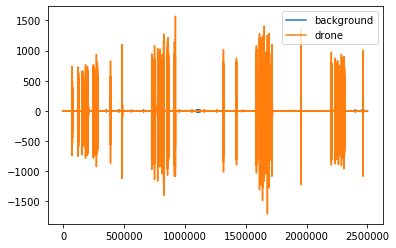

In [13]:
num = random.randint(0, len(background)-1)
channel = 0
plt.plot(background[num][channel], label="background")
plt.plot(drone[num][channel],label="drone")
plt.legend(loc='upper right')

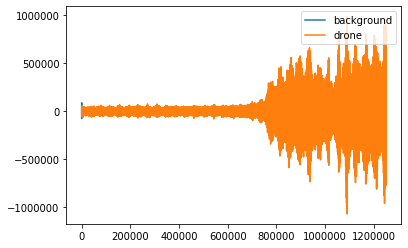

In [14]:
plt.plot(np.fft.rfft(background[num][channel]), label="background")
plt.plot(np.fft.rfft(drone[num][channel]),label="drone")
plt.legend(loc='upper right')

# Train/ test split and data formatting

In [15]:
Y = np.array([0 for i in enumerate(background)] + [1 for i in enumerate(drone)])
X = np.append(background,drone,axis=0)
Y = Y.reshape(-1,1)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [17]:
def split_rf(x_data):
    low = []
    high = []
    for x in x_data:
        low.append(x[0].astype(np.float16).flatten())
        high.append(x[1].astype(np.float16).flatten())
    low = np.array(low)
    high = np.array(high)
    return [low, high]
x_train = split_rf(x_train)
x_test = split_rf(x_test)
    

# Model Specification

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.layers import Input
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

# define two sets of inputs
low_rf  = Input(shape=(X.shape[2],))
high_rf = Input(shape=(X.shape[2],))

# the first branch operates on the first input
x1 = Dense(50 , activation="relu")(low_rf)
# x1 = Dense(50, activation="relu")(x1)
x1 = Model(inputs=low_rf, outputs=x1)

# the second branch operates on the second input
x2 = Dense(50 , activation="relu")(high_rf)
# x2 = Dense(50, activation="relu")(x2)
x2 = Model(inputs=high_rf, outputs=x2)

# combine the output of the two branches
combined = concatenate([x1.output, x2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(10, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[x1.input, x2.input], outputs=z)
model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[2500000,50] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [59]:
model.compile(optimizer ='adam' , loss = "binary_crossentropy", metrics=["accuracy"])

# Parrallelize

In [ ]:
from keras.utils import multi_gpu_model
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer ='adam' , loss = "binary_crossentropy", metrics=["accuracy"])

In [ ]:
parallel_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# Train Model

In [61]:
batch_size =1
epochs = 3
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 56 samples, validate on 24 samples
Epoch 1/3
56/56 [==============================] - 1s 16ms/sample - loss: 0.6044 - accuracy: 0.5714 - val_loss: 0.5621 - val_accuracy: 0.7083
Epoch 2/3
56/56 [==============================] - 0s 5ms/sample - loss: 0.2900 - accuracy: 0.9464 - val_loss: 0.4889 - val_accuracy: 0.7500
Epoch 3/3
56/56 [==============================] - 0s 5ms/sample - loss: 0.0764 - accuracy: 1.0000 - val_loss: 0.5857 - val_accuracy: 0.7500


# Evaluate Model

In [62]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5856816172599792
Test accuracy: 0.75


In [63]:
THRESHOLD = 0.5
predictions = model.predict(x_test)

# predictions = (predictions > THRESHOLD)
print(predictions)

[[0.04631087]
 [0.29837108]
 [0.0757457 ]
 [0.19909757]
 [0.07904682]
 [0.26142627]
 [0.3597027 ]
 [0.366773  ]
 [0.09029669]
 [0.09868279]
 [0.35672975]
 [0.06677434]
 [0.6918491 ]
 [0.0848178 ]
 [0.87143266]
 [0.12248021]
 [0.9741509 ]
 [0.08485252]
 [0.03445619]
 [0.11761299]
 [0.26927862]
 [0.9776531 ]
 [0.06121758]
 [0.31949508]]


## Confusion Matrix

In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, (predictions> THRESHOLD))
print(cm)

[[14  0]
 [ 6  4]]


# Precision recall curve

In [2]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
print(thresholds)

NameError: name 'y_test' is not defined

In [69]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, predictions)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.83


# Free memory

In [ ]:
del X 
del Y
del background
del drone

# Clear GPU

In [ ]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()